# Beyond Hello World, A Computer Vision Example
In the previous exercise you saw how to create a neural network that figured out the problem you were trying to solve. This gave an explicit example of learned behavior. Of course, in that instance, it was a bit of overkill because it would have been easier to write the function Y=2x-1 directly, instead of bothering with using Machine Learning to learn the relationship between X and Y for a fixed set of values, and extending that for all values.

But what about a scenario where writing rules like that is much more difficult -- for example a computer vision problem? Let's take a look at a scenario where we can recognize different items of clothing, trained from a dataset containing 10 different types.

## Start Coding

Let's start with our import of TensorFlow

In [21]:
import tensorflow as tf
print(tf.__version__)

1.11.0


The Fashion MNIST data is available directly in the tf.keras datasets API. You load it like this:

In [22]:
mnist = tf.keras.datasets.fashion_mnist

Calling load_data on this object will give you two sets of two lists, these will be the training and testing values for the graphics that contain the clothing items and their labels.


In [23]:
# data downloaded from: https://github.com/zalandoresearch/fashion-mnist/tree/master/data/fashion

In [24]:
# reference: https://github.com/tensorflow/tensorflow/blob/r1.13/tensorflow/python/keras/datasets/fashion_mnist.py


# Copyright 2017 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Fashion-MNIST dataset.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import gzip
import os

import numpy as np

from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.python.util.tf_export import tf_export


# @tf_export('keras.datasets.fashion_mnist.load_data')
def load_data():
  """Loads the Fashion-MNIST dataset.
  Returns:
      Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
  License:
      The copyright for Fashion-MNIST is held by Zalando SE.
      Fashion-MNIST is licensed under the [MIT license](
      https://github.com/zalandoresearch/fashion-mnist/blob/master/LICENSE).
  """
  dirname = os.path.join('datasets', 'fashion-mnist')
#   base = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/'
  base = '/mnt/external_data/fashion_mnist/'
  files = [
      'train-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz',
      't10k-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz'
  ]

  paths = []
  for fname in files:
#     paths.append(get_file(fname, origin=base + fname, cache_subdir=dirname))
    paths.append(base + fname)

  with gzip.open(paths[0], 'rb') as lbpath:
    y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)

  with gzip.open(paths[1], 'rb') as imgpath:
    x_train = np.frombuffer(
        imgpath.read(), np.uint8, offset=16).reshape(len(y_train), 28, 28)

  with gzip.open(paths[2], 'rb') as lbpath:
    y_test = np.frombuffer(lbpath.read(), np.uint8, offset=8)

  with gzip.open(paths[3], 'rb') as imgpath:
    x_test = np.frombuffer(
        imgpath.read(), np.uint8, offset=16).reshape(len(y_test), 28, 28)

  return (x_train, y_train), (x_test, y_test)

In [25]:
# (training_images, training_labels), (test_images, test_labels) = mnist.load_data()
(training_images, training_labels), (test_images, test_labels) = load_data()

What does these values look like? Let's print a training image, and a training label to see...Experiment with different indices in the array. For example, also take a look at index 42...that's a a different boot than the one at index 0


9
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 

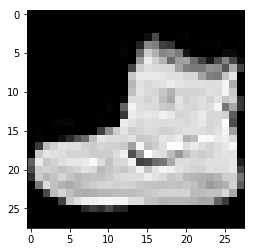

In [26]:
import matplotlib.pyplot as plt
plt.imshow(training_images[0], cmap = 'gray')
print(training_labels[0])
print(training_images[0])

You'll notice that all of the values in the number are between 0 and 255. If we are training a neural network, for various reasons it's easier if we treat all values as between 0 and 1, a process called '**normalizing**'...and fortunately in Python it's easy to normalize a list like this without looping. You do it like this:

In [27]:
training_images  = training_images / 255.0
test_images = test_images / 255.0

Now you might be wondering why there are 2 sets...training and testing -- remember we spoke about this in the intro? The idea is to have 1 set of data for training, and then another set of data...that the model hasn't yet seen...to see how good it would be at classifying values. After all, when you're done, you're going to want to try it out with data that it hadn't previously seen!

Let's now design the model. There's quite a few new concepts here, but don't worry, you'll get the hang of them. 

In [28]:
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(), 
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

**Sequential**: That defines a SEQUENCE of layers in the neural network

**Flatten**: Remember earlier where our images were a square, when you printed them out? Flatten just takes that square and turns it into a 1 dimensional set.

**Dense**: Adds a layer of neurons

Each layer of neurons need an **activation function** to tell them what to do. There's lots of options, but just use these for now. 

**Relu** effectively means "If X>0 return X, else return 0" -- so what it does it it only passes values 0 or greater to the next layer in the network.

**Softmax** takes a set of values, and effectively picks the biggest one, so, for example, if the output of the last layer looks like [0.1, 0.1, 0.05, 0.1, 9.5, 0.1, 0.05, 0.05, 0.05], it saves you from fishing through it looking for the biggest value, and turns it into [0,0,0,0,1,0,0,0,0] -- The goal is to save a lot of coding!


The next thing to do, now the model is defined, is to actually build it. You do this by compiling it with an optimizer and loss function as before -- and then you train it by calling **model.fit ** asking it to fit your training data to your training labels -- i.e. have it figure out the relationship between the training data and its actual labels, so in future if you have data that looks like the training data, then it can make a prediction for what that data would look like. 

In [29]:
model.compile(optimizer = tf.train.AdamOptimizer(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(training_images, training_labels, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 5s 89us/step - loss: 0.4973 - acc: 0.8238
Epoch 2/5
60000/60000 [==============================] - 5s 90us/step - loss: 0.3740 - acc: 0.8652
Epoch 3/5
60000/60000 [==============================] - 5s 88us/step - loss: 0.3339 - acc: 0.8786
Epoch 4/5
60000/60000 [==============================] - 5s 78us/step - loss: 0.3118 - acc: 0.8852
Epoch 5/5
60000/60000 [==============================] - 5s 80us/step - loss: 0.2938 - acc: 0.8909


Once it's done training -- you should see an accuracy value at the end of the final epoch. It might look something like 0.9098. This tells you that your neural network is about 91% accurate in classifying the training data. I.E., it figured out a pattern match between the image and the labels that worked 91% of the time. Not great, but not bad considering it was only trained for 5 epochs and done quite quickly.

But how would it work with unseen data? That's why we have the test images. We can call model.evaluate, and pass in the two sets, and it will report back the loss for each. Let's give it a try:

In [30]:
model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 1s 57us/step


[0.3562069795846939, 0.8697]

For me, that returned a loss of about .8838, which means it was about 88% accurate. As expected it probably would not do as well with *unseen* data as it did with data it was trained on!  As you go through this course, you'll look at ways to improve this. 

To explore further, try the below exercises:


# Exploration Exercises

### Exercise 1:
For this first exercise run the below code: It creates a set of classifications for each of the test images, and then prints the first entry in the classifications. The output, after you run it is a list of numbers. Why do you think this is, and what do those numbers represent? 

In [31]:
classifications = model.predict(test_images)

print(classifications[0])

[1.5811649e-07 1.4002032e-08 3.0908734e-07 4.2334324e-08 3.6183817e-08
 2.4660563e-02 2.9657249e-07 4.7045425e-02 5.8937103e-06 9.2828727e-01]


Hint: try running print(test_labels[0]) -- and you'll get a 9. Does that help you understand why this list looks the way it does? 

In [32]:
print(test_labels[0])

9


### What does this list represent?


1.   It's 10 random meaningless values
2.   It's the first 10 classifications that the computer made
3.   It's the probability that this item is each of the 10 classes



####Answer: 
The correct answer is (3)

The output of the model is a list of 10 numbers. These numbers are a probability that the value being classified is the corresponding value, i.e. the first value in the list is the probability that the handwriting is of a '0', the next is a '1' etc. Notice that they are all VERY LOW probabilities.

For the 7, the probability was .999+, i.e. the neural network is telling us that it's almost certainly a 7.

### How do you know that this list tells you that the item is an ankle boot?


1.   There's not enough information to answer that question
2.   The 10th element on the list is the biggest, and the ankle boot is labelled 9
2.   The ankle boot is label 9, and there are 0->9 elements in the list




####Answer
The correct answer is (2). Both the list and the labels are 0 based, so the ankle boot having label 9 means that it is the 10th of the 10 classes. The list having the 10th element being the highest value means that the Neural Network has predicted that the item it is classifying is most likely an ankle boot

##Exercise 2: 
Let's now look at the layers in your model. Experiment with different values for the dense layer with 512 neurons. What different results do you get for loss, training time etc? Why do you think that's the case? 



In [34]:
import tensorflow as tf
print(tf.__version__)

# mnist = tf.keras.datasets.mnist

# (training_images, training_labels) ,  (test_images, test_labels) = mnist.load_data()
(training_images, training_labels) ,  (test_images, test_labels) = load_data()


training_images = training_images/255.0
test_images = test_images/255.0

model = tf.keras.models.Sequential([tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

model.fit(training_images, training_labels, epochs=5)

model.evaluate(test_images, test_labels)

classifications = model.predict(test_images)

print(classifications[0])
print(test_labels[0])

1.11.0
Epoch 1/5
60000/60000 [==============================] - 14s 229us/step - loss: 0.4706 - acc: 0.8309
Epoch 2/5
60000/60000 [==============================] - 13s 222us/step - loss: 0.3575 - acc: 0.8688
Epoch 3/5
60000/60000 [==============================] - 13s 221us/step - loss: 0.3210 - acc: 0.8811
Epoch 4/5
60000/60000 [==============================] - 13s 222us/step - loss: 0.2961 - acc: 0.8891
Epoch 5/5
10000/10000 [==============================] - 1s 54us/step
[1.3836853e-07 4.2025854e-09 4.0299941e-09 1.5409487e-09 2.4243510e-08
 1.6498910e-03 3.5923605e-08 1.7574304e-01 3.5417695e-08 8.2260680e-01]
9


###Question 1. Increase to 1024 Neurons -- What's the impact?

1. Training takes longer, but is more accurate
2. Training takes longer, but no impact on accuracy
3. Training takes the same time, but is more accurate


####Answer
The correct answer is (1) by adding more Neurons we have to do more calculations, slowing down the process, but in this case they have a good impact -- we do get more accurate. That doesn't mean it's always a case of 'more is better', you can hit the law of diminishing returns very quickly!

##Exercise 3: 

What would happen if you remove the Flatten() layer. Why do you think that's the case? 

You get an error about the shape of the data. It may seem vague right now, but it reinforces the rule of thumb that the first layer in your network should be the same shape as your data. Right now our data is 28x28 images, and 28 layers of 28 neurons would be infeasible, so it makes more sense to 'flatten' that 28,28 into a 784x1. Instead of wriitng all the code to handle that ourselves, we add the Flatten() layer at the begining, and when the arrays are loaded into the model later, they'll automatically be flattened for us.

In [36]:
import tensorflow as tf
print(tf.__version__)

mnist = tf.keras.datasets.mnist

(training_images, training_labels) ,  (test_images, test_labels) = mnist.load_data()

training_images = training_images/255.0
test_images = test_images/255.0

model = tf.keras.models.Sequential([#tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(64, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

model.fit(training_images, training_labels, epochs=5)

model.evaluate(test_images, test_labels)

classifications = model.predict(test_images)

print(classifications[0])
print(test_labels[0])

1.11.0


Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz: None -- [Errno 111] Connection refused

##Exercise 4: 

Consider the final (output) layers. Why are there 10 of them? What would happen if you had a different amount than 10? For example, try training the network with 5

You get an error as soon as it finds an unexpected value. Another rule of thumb -- the number of neurons in the last layer should match the number of classes you are classifying for. In this case it's the digits 0-9, so there are 10 of them, hence you should have 10 neurons in your final layer.

In [37]:
import tensorflow as tf
print(tf.__version__)

mnist = tf.keras.datasets.mnist

(training_images, training_labels) ,  (test_images, test_labels) = mnist.load_data()

training_images = training_images/255.0
test_images = test_images/255.0

model = tf.keras.models.Sequential([tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(64, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(5, activation=tf.nn.softmax)])

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy')

model.fit(training_images, training_labels, epochs=5)

model.evaluate(test_images, test_labels)

classifications = model.predict(test_images)

print(classifications[0])
print(test_labels[0])

1.11.0


Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz: None -- [Errno 111] Connection refused

##Exercise 5: 

Consider the effects of additional layers in the network. What will happen if you add another layer between the one with 512 and the final layer with 10. 

Ans: There isn't a significant impact -- because this is relatively simple data. For far more complex data (including color images to be classified as flowers that you'll see in the next lesson), extra layers are often necessary. 

In [40]:
import tensorflow as tf
print(tf.__version__)

# mnist = tf.keras.datasets.mnist

# (training_images, training_labels) ,  (test_images, test_labels) = mnist.load_data()
(training_images, training_labels) ,  (test_images, test_labels) = load_data()


training_images = training_images/255.0
test_images = test_images/255.0

model = tf.keras.models.Sequential([tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(256, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

model.fit(training_images, training_labels, epochs=5)

model.evaluate(test_images, test_labels)

classifications = model.predict(test_images)

print(classifications[0])
print(test_labels[0])

1.11.0
Epoch 1/5
60000/60000 [==============================] - 10s 160us/step - loss: 0.4684 - acc: 0.8307
Epoch 2/5
60000/60000 [==============================] - 9s 154us/step - loss: 0.3551 - acc: 0.8697
Epoch 3/5
60000/60000 [==============================] - 9s 152us/step - loss: 0.3186 - acc: 0.8817
Epoch 4/5
60000/60000 [==============================] - 9s 151us/step - loss: 0.2970 - acc: 0.8896
Epoch 5/5
10000/10000 [==============================] - 1s 59us/step
[2.5401243e-07 1.5718930e-08 1.7912251e-08 9.4746619e-09 1.5802252e-09
 3.1970069e-04 1.0795821e-06 1.0840087e-02 1.0152738e-08 9.8883891e-01]
9


#Exercise 6: 

Consider the impact of training for more or less epochs. Why do you think that would be the case? 

Try 15 epochs -- you'll probably get a model with a much better loss than the one with 5
Try 30 epochs -- you might see the loss value stops decreasing, and sometimes increases. This is a side effect of something called 'overfitting' which you can learn about [somewhere] and it's something you need to keep an eye out for when training neural networks. There's no point in wasting your time training if you aren't improving your loss, right! :)

In [43]:
import tensorflow as tf
print(tf.__version__)

# mnist = tf.keras.datasets.mnist

(training_images, training_labels) ,  (test_images, test_labels) = load_data()

training_images = training_images/255.0
test_images = test_images/255.0

model = tf.keras.models.Sequential([tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy')

model.fit(training_images, training_labels, epochs=30)

model.evaluate(test_images, test_labels)

classifications = model.predict(test_images)

print(classifications[34])
print(test_labels[34])

1.11.0
Epoch 1/30
60000/60000 [==============================] - 6s 104us/step - loss: 0.5008
Epoch 2/30
60000/60000 [==============================] - 5s 84us/step - loss: 0.3755
Epoch 3/30
60000/60000 [==============================] - 5s 77us/step - loss: 0.3366
Epoch 4/30
60000/60000 [==============================] - 6s 92us/step - loss: 0.3127
Epoch 5/30
60000/60000 [==============================] - 5s 89us/step - loss: 0.2950
Epoch 6/30
60000/60000 [==============================] - 5s 85us/step - loss: 0.2812
Epoch 7/30
60000/60000 [==============================] - 5s 89us/step - loss: 0.2692
Epoch 8/30
60000/60000 [==============================] - 6s 94us/step - loss: 0.2574
Epoch 9/30
60000/60000 [==============================] - 5s 84us/step - loss: 0.2491
Epoch 10/30
60000/60000 [==============================] - 6s 93us/step - loss: 0.2403
Epoch 11/30
60000/60000 [==============================] - 6s 93us/step - loss: 0.2316
Epoch 12/30
60000/60000 [===================

#Exercise 7: 

Before you trained, you normalized the data, going from values that were 0-255 to values that were 0-1. What would be the impact of removing that? Here's the complete code to give it a try. Why do you think you get different results? 

In [44]:
import tensorflow as tf
print(tf.__version__)
# mnist = tf.keras.datasets.mnist
(training_images, training_labels), (test_images, test_labels) = load_data()
# training_images=training_images/255.0
# test_images=test_images/255.0
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.fit(training_images, training_labels, epochs=5)
model.evaluate(test_images, test_labels)
classifications = model.predict(test_images)
print(classifications[0])
print(test_labels[0])

1.11.0
Epoch 1/5
60000/60000 [==============================] - 9s 143us/step - loss: 14.5063
Epoch 2/5
60000/60000 [==============================] - 8s 132us/step - loss: 14.5063
Epoch 3/5
60000/60000 [==============================] - 8s 134us/step - loss: 14.5063
Epoch 4/5
60000/60000 [==============================] - 8s 133us/step - loss: 14.5063
Epoch 5/5
10000/10000 [==============================] - 0s 48us/step
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
9


#Exercise 8: 

Earlier when you trained for extra epochs you had an issue where your loss might change. It might have taken a bit of time for you to wait for the training to do that, and you might have thought 'wouldn't it be nice if I could stop the training when I reach a desired value?' -- i.e. 95% accuracy might be enough for you, and if you reach that after 3 epochs, why sit around waiting for it to finish a lot more epochs....So how would you fix that? Like any other program...you have callbacks! Let's see them in action...

In [54]:
import tensorflow as tf
print(tf.__version__)

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
#     if(logs.get('acc')> 0.6):
#       print("\nReached 60% accuracy so cancelling training!")
#       self.model.stop_training = True
    if(logs.get('loss')< 0.4):
      print("\nReached < 0.4 loss so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()
# mnist = tf.keras.datasets.fashion_mnist
# (training_images, training_labels), (test_images, test_labels) = mnist.load_data()
(training_images, training_labels), (test_images, test_labels) = load_data()

training_images=training_images/255.0
test_images=test_images/255.0
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['acc'])
model.fit(training_images, training_labels, epochs=5, callbacks=[callbacks])




1.11.0
Epoch 1/5
60000/60000 [==============================] - 9s 146us/step - loss: 0.4752 - acc: 0.8305
Epoch 2/5
59872/60000 [============================>.] - ETA: 0s - loss: 0.3594 - acc: 0.8690
Reached < 0.4 loss so cancelling training!
60000/60000 [==============================] - 8s 139us/step - loss: 0.3595 - acc: 0.8690
